In [1]:
#setup 
import sys
import numpy as np
import pandas as pd 
from tkinter import filedialog
import matplotlib.pyplot as plt
import os 
import glob
import csv
import itertools
import struct

In [2]:
#Dialog box 
initialdir='/home/jkusz/github/king_jason/Project-2/' #assign a directory 
#filepaths= filedialog.askopenfilename(multiple=True, initialdir=initialdir,title='Select a File', filetypes=(("ASC Files",".ASC"),))
#^opens dialogbox to select multiple files that end in .ASC
#print(filepaths)

In [3]:
def list_files(filepath, filetype):
    paths=[]
    for root, dirs, files in os.walk(filepath):
        for name in files:
            if name.lower().endswith(filetype.lower()):
                paths.append(name)
    return(paths)

In [4]:
def read_spe(spefile):

    # open SPE file as binary input
    spe = open(spefile, "rb")

    # Header length is a fixed number
    nBytesInHeader = 4100

    # Read the entire header
    header = spe.read(nBytesInHeader)

    # Date of the observation
    # (format is MM/DD/YY e.g. 02/25/21)
    date = struct.unpack_from("9s", header, offset=20)[0].decode('utf-8','replace')

    # Exposure time (float)
    exp_sec = struct.unpack_from("f", header, offset=10)[0]

    # Data type (0=float, 1=long integer, 2=integer, 3=unsigned int)
    data_type = struct.unpack_from("h", header, offset=108)[0]

    # CCD Chip Temperature (Degrees C)
    # detectorTemperature = struct.unpack_from("f", header, offset=36)[0]

    accumulations = struct.unpack_from("l", header, offset=668)[0]

    #total run time (in seconds)
    total_collection_time = exp_sec * accumulations

    # print ("exp_date     = ", date)
    # print ("exp_sec      = ", exp_sec)
    # print ("accums       = ", accumulations)
    # print ("run time (s) = ", total_collection_time)
    # print ("data_type    = ", data_type)
    # print ("detectorTemperature [C] = ", detectorTemperature)

    # Number of pixels on x-axis and y-axis
    nx = struct.unpack_from("H", header, offset=42)[0]
    ny = struct.unpack_from("H", header, offset=656)[0]

    # Number of image frames in this SPE file
    nframes = struct.unpack_from("l", header, offset=1446)[0]

    # print ("nx, ny, nframes = ", nx, ", ", ny, ", ", nframes)

    if data_type == 0:
        # float (4 bytes)
        dataTypeStr = "f"  #untested
        bytesPerPixel = 4
        dtype = "float32"
    elif data_type == 1:
        # long (4 bytes)
        dataTypeStr = "l"  #untested
        bytesPerPixel = 4
        dtype = "int32"
    elif data_type == 2:
        # short (2 bytes)
        dataTypeStr = "h"  #untested
        bytesPerPixel = 2
        dtype = "int32"
    elif data_type == 3:  
        # unsigned short (2 bytes)
        dataTypeStr = "H"  # 16 bits in python on intel mac
        bytesPerPixel = 2
        dtype = "int32"  # for numpy.array().
        # other options include:
        # IntN, UintN, where N = 8,16,32 or 64
        # and Float32, Float64, Complex64, Complex128
        # but need to verify that pyfits._ImageBaseHDU.ImgCode cna handle it
        # right now, ImgCode must be float32, float64, int16, int32, int64 or uint8
    else:
        print ("unknown data type")
        print ("returning...")
        sys.exit()

    npixels = nx*ny
    npixStr = str(npixels)
    fmtStr  = npixStr+dataTypeStr
    # print ("fmtStr = ", fmtStr)

    # How many bytes per image?
    nbytesPerFrame = npixels*bytesPerPixel
    # print ("nbytesPerFrame = ", nbytesPerFrame)

    """Start of X Calibration Structure (although I added things to it that I thought were relevant,
        like the center wavelength..."""
    xcalib = {}

    #float SpecCenterWlNm # 72 Center Wavelength in Nm
    xcalib['SpecCenterWlNm'] = struct.unpack_from("f", header, offset=72)[0]

    #SHORT SpecGlueFlag 76 T/F File is Glued
    xcalib['SpecGlueFlag'] = bool( struct.unpack_from("h", header, offset=76)[0] )

    #float SpecGlueStartWlNm 78 Starting Wavelength in Nm
    xcalib['SpecGlueStartWlNm'] = struct.unpack_from("f", header, offset=78)[0]

    #float SpecGlueEndWlNm 82 Starting Wavelength in Nm
    xcalib['SpecGlueEndWlNm'] = struct.unpack_from("f", header, offset=82)[0]

    #float SpecGlueMinOvrlpNm 86 Minimum Overlap in Nm
    xcalib['SpecGlueMinOvrlpNm'] = struct.unpack_from("f", header, offset=86)[0]

    #float SpecGlueFinalResNm 90 Final Resolution in Nm
    xcalib['SpecGlueFinalResNm'] = struct.unpack_from("f", header, offset=90)[0]

    #  short   BackGrndApplied              150  1 if background subtraction done
    xcalib['BackgroundApplied'] = struct.unpack_from("h", header, offset=150)[0]
    BackgroundApplied=False
    if xcalib['BackgroundApplied']==1: BackgroundApplied=True

    #  float   SpecGrooves                  650  Spectrograph Grating Grooves
    xcalib['SpecGrooves'] = struct.unpack_from("f", header, offset=650)[0]

    #  short   flatFieldApplied             706  1 if flat field was applied.
    xcalib['flatFieldApplied'] = struct.unpack_from("h", header, offset=706)[0]
    flatFieldApplied=False
    if xcalib['flatFieldApplied']==1: flatFieldApplied=True

    #double offset # 3000 offset for absolute data scaling */
    xcalib['offset'] = struct.unpack_from("d", header, offset=3000)[0]

    #double factor # 3008 factor for absolute data scaling */
    xcalib['factor'] = struct.unpack_from("d", header, offset=3008)[0]

    #char current_unit # 3016 selected scaling unit */
    xcalib['current_unit'] = ord(struct.unpack_from("c", header, offset=3016)[0])

    #char calib_valid # 3098 flag if calibration is valid */
    xcalib['calib_valid'] = ord(struct.unpack_from("c", header, offset=3098)[0])

    #char input_unit # 3099 current input units for */
    xcalib['input_unit'] = ord(struct.unpack_from("c", header, offset=3099)[0])
    """/* "calib_value" */"""

    #char polynom_unit # 3100 linear UNIT and used */
    xcalib['polynom_unit'] = ord(struct.unpack_from("c", header, offset=3100)[0])
    """/* in the "polynom_coeff" */"""

    #char polynom_order # 3101 ORDER of calibration POLYNOM */
    xcalib['polynom_order'] = ord(struct.unpack_from("c", header, offset=3101)[0])

    #char calib_count # 3102 valid calibration data pairs */
    xcalib['calib_count'] = ord(struct.unpack_from("c", header, offset=3102)[0])

    #double pixel_position[10];/* 3103 pixel pos. of calibration data */
    xcalib['pixel_position'] = struct.unpack_from("10d", header, offset=3103)

    #double calib_value[10] # 3183 calibration VALUE at above pos */
    xcalib['calib_value'] = struct.unpack_from("10d", header, offset=3183)

    #double polynom_coeff[6] # 3263 polynom COEFFICIENTS */
    xcalib['polynom_coeff'] = struct.unpack_from("6d", header, offset=3263)

    #double laser_position # 3311 laser wavenumber for relativ WN */
    xcalib['laser_position'] = struct.unpack_from("d", header, offset=3311)[0]

    #setup data dictionary
    spedict = {'data':[], 
                'EXPOSURE':exp_sec,
                'SPEFNAME':spefile,
                'OBSDATE':date,
                'XCALIB':xcalib,
                'ACCUMULATIONS':accumulations,
                'FLATFIELD':flatFieldApplied,
                'BACKGROUND':BackgroundApplied
                }

    for ii in range(nframes):
        iistr = str(ii)
        data = spe.read(nbytesPerFrame)
        # read pixel values into a 1-D numpy array. the "=" forces it to use
        # standard python datatype size (4bytes for 'l') rather than native
        # (which on 64bit is 8bytes for 'l', for example).
        # See http://docs.python.org/library/struct.html
        dataArr = np.array(struct.unpack_from("="+fmtStr, data, offset=0),
                            dtype=dtype)

        # Resize array to nx by ny pixels
        # notice order... (y,x)
        dataArr.resize((ny, nx))
        # print (dataArr.shape)

        # Push this image frame data onto the end of the list of images
        # but first cast the datatype to float (if it's not already)
        # this isn't necessary, but shouldn't hurt and could save me
        # from doing integer math when i really meant floating-point...
        spedict['data'].append(dataArr.astype(float))

    xpixel_calib_coeff_array = np.flip(np.asarray(spedict['XCALIB']['polynom_coeff']))
    xpixel_array = range(1,1+int(spedict['XCALIB']['pixel_position'][1]))
    # print(xpixel_calib_coeff_array)
    # print(xpixel_array)

    # Finds wavelength from pixels using calibration coefficients
    wavelengthData = np.polyval(xpixel_calib_coeff_array,xpixel_array)
    # print("Wavelength data is... ", wavelengthData)
    # print("Does this roughly match?: ", spedict['XCALIB']['calib_value'][:2])

    # Only pulls first spectrum. (we generally only collect one spectrum and accumulate anyway)
    # Could easily change to take average of multiple spectra.
    intensityData = spedict['data'][0][0]

    #test to see that x and y data is correct
    # plt.plot(wavelengthData,intensityData)
    # plt.show()

    return wavelengthData, intensityData, spedict

In [42]:
filetype = "." + input("'asc' or 'spe' filetype?: ")
filenames = list_files(initialdir, filetype)
print(filenames)

'asc' or 'spe' filetype?: spe
['CFS3-2.SPE', 'CFS2-2.SPE', 'CFS1-2.SPE', 'BLANK.SPE']


In [36]:
#remove .ASC from filenames for legend
#create new list
molecule_names=[] 
#for everyname in filenames split name and .asc 
#append name to new list 
for name in filenames:
    m=os.path.splitext(name)[0]
    molecule_names.append(m)
print(molecule_names)

['CFS3-2', 'CFS2-2', 'CFS1-2', 'BLANK']


In [37]:
#find index of Blank measurement 
#blank_pos=molecule_names.index('BLANK')
#print(blank_pos)
#blank_cols=[blank_pos*2,blank_pos*2+1]
#print(blank_cols)

In [38]:
#Compliling Files Into List of Lists
headerList=['Wavelength', 'Intensity']
df=pd.DataFrame()
if ".asc" in str.lower(filenames[0]):
    for element in filenames:
        try:
            df2=pd.read_csv(initialdir+element, usecols=['Wavelength','Intensity'])
            df=pd.concat([df,df2], axis=1)
        except ValueError:
            df2=pd.read_csv(initialdir+element, sep="\,*\s+",header=None, usecols=[0,2], names=headerList, engine="python")
            df=pd.concat([df,df2], axis=1)
if ".spe" in str.lower(filenames[0]):
    df2=pd.DataFrame()
    for element in filenames:
        xdata, ydata, spedict = read_spe(initialdir+element)
        df2['Wavelength'] = xdata
        df2['Intensity'] = ydata
        df=pd.concat([df,df2], axis=1)
print(df)

      Wavelength   Intensity  Wavelength    Intensity  Wavelength  \
0     533.000000  957.726868  533.000000  6788.349121  533.000000   
1     533.067728  917.308411  533.067728  6087.146484  533.067728   
2     533.135457  812.924072  533.135457  5503.548340  533.135457   
3     533.203185  743.781311  533.203185  5119.939453  533.203185   
4     533.270914  694.462402  533.270914  4646.287598  533.270914   
...          ...         ...         ...          ...         ...   
1472  632.696205  134.395020  632.696205   289.074738  632.696205   
1473  632.763934  160.550568  632.763934   297.460022  632.763934   
1474  632.831662  151.839111  632.831662   286.564880  632.831662   
1475  632.899390  109.046257  632.899390   314.701080  632.899390   
1476  632.967119  122.427048  632.967119   275.348755  632.967119   

        Intensity  Wavelength   Intensity  
0     3532.765869  533.000000  261.979248  
1     3258.522461  533.067728  255.286530  
2     3041.781738  533.135457  214.0652

In [39]:
#create individual names for each col
cols = []
count = 1
for column in df.columns:
    if column=='Wavelength':
        cols.append(f'Wavelength_{count}')
        count+=1
        continue
    cols.append(column)
df.columns = cols
cols = []
count = 1
for column in df.columns:
    if column=='Intensity':
        cols.append(f'Intensity_{count}')
        count+=1
        continue
    cols.append(column)
df.columns = cols
print(df)

      Wavelength_1  Intensity_1  Wavelength_2  Intensity_2  Wavelength_3  \
0       533.000000   957.726868    533.000000  6788.349121    533.000000   
1       533.067728   917.308411    533.067728  6087.146484    533.067728   
2       533.135457   812.924072    533.135457  5503.548340    533.135457   
3       533.203185   743.781311    533.203185  5119.939453    533.203185   
4       533.270914   694.462402    533.270914  4646.287598    533.270914   
...            ...          ...           ...          ...           ...   
1472    632.696205   134.395020    632.696205   289.074738    632.696205   
1473    632.763934   160.550568    632.763934   297.460022    632.763934   
1474    632.831662   151.839111    632.831662   286.564880    632.831662   
1475    632.899390   109.046257    632.899390   314.701080    632.899390   
1476    632.967119   122.427048    632.967119   275.348755    632.967119   

      Intensity_3  Wavelength_4  Intensity_4  
0     3532.765869    533.000000   261.97

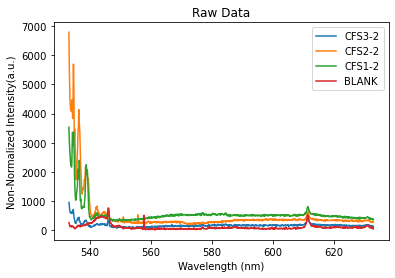

In [40]:
#Plotting Raw Data
test='Intensity'
IntCols = [idx for idx in df if idx.lower().startswith(test.lower())]
#print(IntCols)
df.plot(x='Wavelength_1', y=IntCols)
plt.title('Raw Data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Non-Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [41]:
#Skip first 300 rows to get rid of rayleigh line
df_no_rayleigh=df.drop(df.index[0:75])
#leaves rows as 250-575
#reset index becasuse it causes problems later when concating 
df_no_rayleigh.reset_index(drop=True, inplace=True)
print(df_no_rayleigh)

      Wavelength_1  Intensity_1  Wavelength_2  Intensity_2  Wavelength_3  \
0       538.079630   297.800720    538.079630  1742.005127    538.079630   
1       538.147358   324.386139    538.147358  1702.259766    538.147358   
2       538.215087   327.797546    538.215087  1695.296631    538.215087   
3       538.282815   321.909210    538.282815  1731.936768    538.282815   
4       538.350544   338.737244    538.350544  1916.393433    538.350544   
...            ...          ...           ...          ...           ...   
1397    632.696205   134.395020    632.696205   289.074738    632.696205   
1398    632.763934   160.550568    632.763934   297.460022    632.763934   
1399    632.831662   151.839111    632.831662   286.564880    632.831662   
1400    632.899390   109.046257    632.899390   314.701080    632.899390   
1401    632.967119   122.427048    632.967119   275.348755    632.967119   

      Intensity_3  Wavelength_4  Intensity_4  
0      905.514465    538.079630   184.47

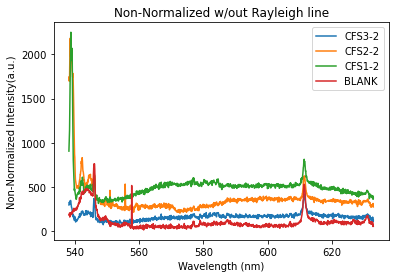

In [12]:
#Plotting Non-Normalized w/out Rayleigh line n Wavelength (nm)
test='Intensity'
IntCols = [idx for idx in df_no_rayleigh if idx.lower().startswith(test.lower())]
#print(IntCols)
df_no_rayleigh.plot(x='Wavelength_1', y=IntCols)
plt.title('Non-Normalized w/out Rayleigh line')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Non-Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [13]:
#Wavelength (nm) and Normalized Intensity 
#create list of columns that start with Intensity
test='Intensity'
test2='Wavelength'
IntCols = [idx for idx in df_no_rayleigh if idx.lower().startswith(test.lower())]
WavCols= [idx for idx in df_no_rayleigh if idx.lower().startswith(test2.lower())]
df_normalized=pd.DataFrame()
#for columns in df if they start with Intensity 
#apply calculation to columns that start with Intensity 
for col in df_no_rayleigh:
    if col.startswith(test):
        df_normalized[IntCols] = (df_no_rayleigh[IntCols].apply(lambda x: x/x.max())) #divide each number in a column by the max of that column
    if col.startswith(test2):
        df_normalized[WavCols] = df_no_rayleigh[WavCols]
print(df_normalized)

      Wavelength_1  Wavelength_2  Wavelength_3  Wavelength_4  Intensity_1  \
0       538.079630    538.079630    538.079630    538.079630     0.710818   
1       538.147358    538.147358    538.147358    538.147358     0.774274   
2       538.215087    538.215087    538.215087    538.215087     0.782417   
3       538.282815    538.282815    538.282815    538.282815     0.768362   
4       538.350544    538.350544    538.350544    538.350544     0.808529   
...            ...           ...           ...           ...          ...   
1397    632.696205    632.696205    632.696205    632.696205     0.320786   
1398    632.763934    632.763934    632.763934    632.763934     0.383217   
1399    632.831662    632.831662    632.831662    632.831662     0.362423   
1400    632.899390    632.899390    632.899390    632.899390     0.260281   
1401    632.967119    632.967119    632.967119    632.967119     0.292220   

      Intensity_2  Intensity_3  Intensity_4  
0        0.799062     0.40271

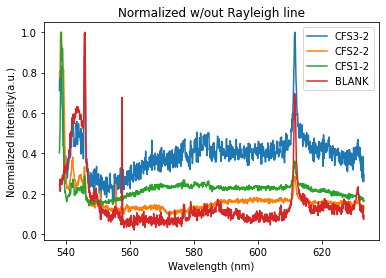

In [14]:
#Plotting Normalized w/out Rayleigh line in Wavelength (nm)
#probably dont need this everytime since IntCols is defined above
test='Intensity'
IntCols = [idx for idx in df_normalized if idx.lower().startswith(test.lower())]
#print(IntCols)
df_normalized.plot(x='Wavelength_1', y=IntCols)
plt.title('Normalized w/out Rayleigh line')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [15]:
#Raman Sh cm^-1 and Normalized Intensity 
#setup numbers for conversion 
test='Intensity'
test2='Wavelength'
IntCols = [idx for idx in df_no_rayleigh if idx.lower().startswith(test.lower())]
WavCols= [idx for idx in df_no_rayleigh if idx.lower().startswith(test2.lower())]
Excitation_Wavelength=532
a=10**7/Excitation_Wavelength
#for columns in df if they start with Intensity 
#apply calculation to columns that start with Intensity 
df_raman_shift=pd.DataFrame()
for col in df:
    if col.startswith(test):
        df_raman_shift[IntCols] = (df_normalized[IntCols])
    if col.startswith(test2):
        df_raman_shift[WavCols]= (df_normalized[WavCols].apply(lambda x:-10**7/x + a))
print(df_raman_shift)

      Wavelength_1  Wavelength_2  Wavelength_3  Wavelength_4  Intensity_1  \
0       212.382617    212.382617    212.382617    212.382617     0.710818   
1       214.721578    214.721578    214.721578    214.721578     0.774274   
2       217.059951    217.059951    217.059951    217.059951     0.782417   
3       219.397735    219.397735    219.397735    219.397735     0.768362   
4       221.734931    221.734931    221.734931    221.734931     0.808529   
...            ...           ...           ...           ...          ...   
1397   2991.618719   2991.618719   2991.618719   2991.618719     0.320786   
1398   2993.310460   2993.310460   2993.310460   2993.310460     0.383217   
1399   2995.001839   2995.001839   2995.001839   2995.001839     0.362423   
1400   2996.692856   2996.692856   2996.692856   2996.692856     0.260281   
1401   2998.383511   2998.383511   2998.383511   2998.383511     0.292220   

      Intensity_2  Intensity_3  Intensity_4  
0        0.799062     0.40271

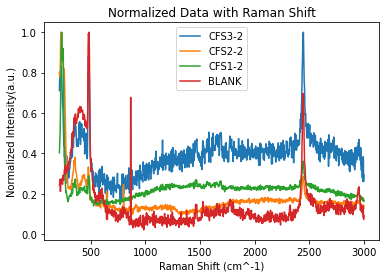

In [16]:
#Plotting Normalized w/out Rayleigh line in Wavenumber (cm^-1)
test='Intensity'
IntCols = [idx for idx in df_raman_shift if idx.lower().startswith(test.lower())]
#print(IntCols)2
df_raman_shift.plot(x='Wavelength_1', y=IntCols)
plt.title('Normalized Data with Raman Shift')
plt.xlabel('Raman Shift (cm^-1)')
plt.ylabel('Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [17]:
IntCols1 = [idx for idx in df if idx.lower().startswith(test.lower())]
y1=IntCols1
IntCols2 = [idx for idx in df_no_rayleigh if idx.lower().startswith(test.lower())]
y2=IntCols2
IntCols3 = [idx for idx in df_normalized if idx.lower().startswith(test.lower())]
y3=IntCols3
IntCols4 = [idx for idx in df_raman_shift if idx.lower().startswith(test.lower())]
y4=IntCols4
#print

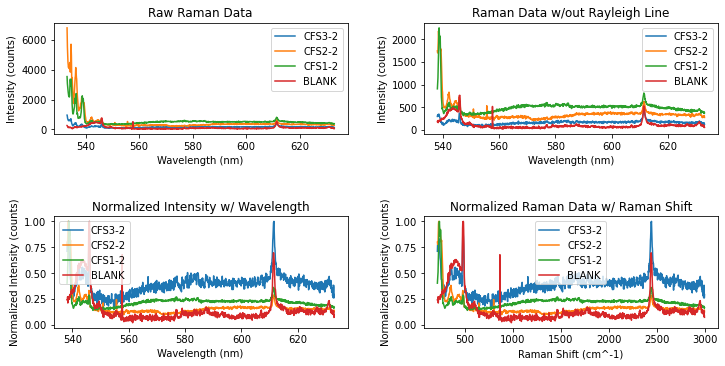

In [18]:
#setup 4 subplots 
fig, ((ax1, ax2),(ax3, ax4))= plt.subplots(nrows=2, ncols=2,figsize=(10,5))
#raw data plot
ax1=plt.subplot(2,2,1)
df.plot(x='Wavelength_1', y=y1, ax=ax1)
ax1.set_title("Raw Raman Data")
plt.legend(molecule_names)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Intensity (counts)')
#witout rayleigh line
ax2=plt.subplot(2,2,2)
df_no_rayleigh.plot(x='Wavelength_1', y=y2, ax=ax2)
ax2.set_title("Raman Data w/out Rayleigh Line")
plt.legend(molecule_names)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Intensity (counts)')
#normalized
ax3=plt.subplot(2,2,3)
df_normalized.plot(x='Wavelength_1', y=y3, ax=ax3)
ax3.set_title("Normalized Intensity w/ Wavelength")
plt.legend(molecule_names)
ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('Normalized Intensity (counts)')
#raman shift
ax4=plt.subplot(2,2,4)
df_raman_shift.plot(x='Wavelength_1', y=y4, ax=ax4)
ax4.set_title("Normalized Raman Data w/ Raman Shift")
plt.legend(molecule_names)
ax4.set_xlabel('Raman Shift (cm^-1)')
ax4.set_ylabel('Normalized Intensity (counts)')
#add y x lables and titles
#fix spacing of graphs
#Intensity (counts)
#Normalized Intensity (counts)
plt.tight_layout(pad=0.4, w_pad=3.0, h_pad=3.5)
# plt.savefig("/home/jasonk0401/Desktop/UROP/RamanGraphs7.png",transparent=True, dpi=300)
plt.show()

In [19]:
#Subtracting the Blank from each measurement 

In [20]:
#find index of Blank measurement 
try:
    blank_pos=molecule_names.index('BLANK')
except:
    print("No Blank!")
    sys.exit()

#print(blank_pos)
indices=[blank_pos*2,blank_pos*2+1]
#print(indices)
blank_wav=blank_pos*2
#print(blank_wav)
blank_int=blank_pos*2+1
#print(blank_int)
col_names=(list(df.columns))
#print(col_names)
blank_wav_name=col_names[blank_wav]
print(blank_wav_name)
blank_int_name=col_names[blank_int]
print(blank_int_name)

Wavelength_4
Intensity_4


In [21]:
#a=df[blank_int_name]
#print(a)
#print(df[IntCols])
#df2[IntCols]=df[IntCols].subtract(a, axis=1)
#print(df2[IntCols])

In [22]:
#Another way of subtracting the blank
#test='Intensity'
#test2='Wavelength'
#IntCols = [idx for idx in df if idx.lower().startswith(test.lower())]
#WavCols= [idx for idx in df if idx.lower().startswith(test2.lower())]
#df_signal=pd.DataFrame()
#print(df[IntCols])
#a=df[IntCols]-df[IntCols]
#print(a)
#df_signal=pd.DataFrame()
#for col in df[IntCols]:
    #print(df[col])
    #df_signal[col]=df[col]-df[blank_int_name]
#for col in df[WavCols]:
    #df_signal[col]=df[col]
#print(df_signal)


In [23]:
test='Intensity'
test2='Wavelength'
IntCols = [idx for idx in df if idx.lower().startswith(test.lower())]
WavCols= [idx for idx in df if idx.lower().startswith(test2.lower())]
df_signal=pd.DataFrame()
for col in df:
    if col.startswith(test):
        df_signal[col]=df[col]-df[blank_int_name]
    if col.startswith(test2):
        df_signal[col]=df[col]
print(df_signal)


      Wavelength_1  Intensity_1  Wavelength_2  Intensity_2  Wavelength_3  \
0       533.000000   695.747620    533.000000  6526.369873    533.000000   
1       533.067728   662.021881    533.067728  5831.859955    533.067728   
2       533.135457   598.858826    533.135457  5289.483093    533.135457   
3       533.203185   547.856506    533.203185  4924.014648    533.203185   
4       533.270914   513.349182    533.270914  4465.174377    533.270914   
...            ...          ...           ...          ...           ...   
1472    632.696205    60.026688    632.696205   214.706406    632.696205   
1473    632.763934    59.503883    632.763934   196.413338    632.763934   
1474    632.831662    92.001461    632.831662   226.727230    632.831662   
1475    632.899390    36.544479    632.899390   242.199303    632.899390   
1476    632.967119    66.870110    632.967119   219.791817    632.967119   

      Intensity_3  Wavelength_4  Intensity_4  
0     3270.786621    533.000000         

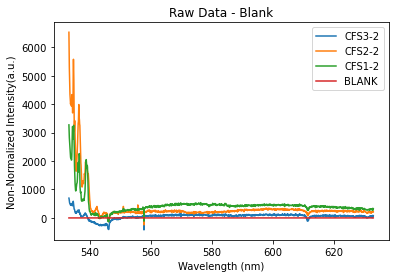

In [24]:
#Plotting Data - Blank
test='Intensity'
IntCols = [idx for idx in df_signal if idx.lower().startswith(test.lower())]
#print(IntCols)
df_signal.plot(x='Wavelength_1', y=IntCols)
plt.title('Raw Data - Blank')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Non-Normalized Intensity(a.u.)')
plt.legend(molecule_names)

      Wavelength_1  Intensity_1  Wavelength_2  Intensity_2  Wavelength_3  \
0       541.127408  -147.403290    541.127408   172.261932    541.127408   
1       541.195136  -161.632263    541.195136   206.671295    541.195136   
2       541.262865  -147.892456    541.262865   231.153503    541.262865   
3       541.330593  -182.405899    541.330593   218.354706    541.330593   
4       541.398322  -182.367752    541.398322   199.779694    541.398322   
...            ...          ...           ...          ...           ...   
1352    632.696205    60.026688    632.696205   214.706406    632.696205   
1353    632.763934    59.503883    632.763934   196.413338    632.763934   
1354    632.831662    92.001461    632.831662   226.727230    632.831662   
1355    632.899390    36.544479    632.899390   242.199303    632.899390   
1356    632.967119    66.870110    632.967119   219.791817    632.967119   

      Intensity_3  Wavelength_4  Intensity_4  
0      133.144867    541.127408         

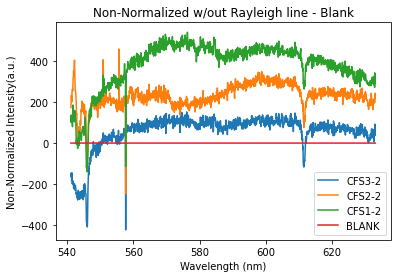

In [25]:
#Skip first 300 rows to get rid of rayleigh line
df_signal_no_rayleigh=df_signal.drop(df.index[0:120])
#leaves rows as 250-575
#reset index becasuse it causes problems later when concating 
df_signal_no_rayleigh.reset_index(drop=True, inplace=True)
print(df_signal_no_rayleigh)
#Plotting Non-Normalized w/out Rayleigh line n Wavelength (nm)
test='Intensity'
IntCols = [idx for idx in df_signal_no_rayleigh if idx.lower().startswith(test.lower())]
#print(IntCols)
df_signal_no_rayleigh.plot(x='Wavelength_1', y=IntCols)
plt.title('Non-Normalized w/out Rayleigh line - Blank')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Non-Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [26]:
#Wavelength (nm) and Normalized Intensity 
#create list of columns that start with Intensity
test='Intensity'
test2='Wavelength'
IntCols = [idx for idx in df_signal_no_rayleigh if idx.lower().startswith(test.lower())]
WavCols= [idx for idx in df_signal_no_rayleigh if idx.lower().startswith(test2.lower())]
df_signal_normalized=pd.DataFrame() 
#find area under curve/sum of the column
#df.sum(axis=0)
#for columns in df if they start with Intensity 
#apply calculation to columns that start with Intensity

In [27]:
for col in df_signal_no_rayleigh:
    if col.startswith(test):
        a=df_signal_no_rayleigh[col].sum(axis=0)
        print(a)
        df_signal_normalized[col] = df_signal_no_rayleigh[col].apply(lambda x: x/a) #divide each number in a column by the sum of that column
#         print(df_signal_normalized[col])
    if col.startswith(test2):
        df_signal_normalized[WavCols] = df_signal_no_rayleigh[WavCols]
print(df_signal_normalized)

75556.8335609436
311261.1159248352
514131.7242012024
0.0
      Wavelength_1  Wavelength_2  Wavelength_3  Wavelength_4  Intensity_1  \
0       541.127408    541.127408    541.127408    541.127408    -0.001951   
1       541.195136    541.195136    541.195136    541.195136    -0.002139   
2       541.262865    541.262865    541.262865    541.262865    -0.001957   
3       541.330593    541.330593    541.330593    541.330593    -0.002414   
4       541.398322    541.398322    541.398322    541.398322    -0.002414   
...            ...           ...           ...           ...          ...   
1352    632.696205    632.696205    632.696205    632.696205     0.000794   
1353    632.763934    632.763934    632.763934    632.763934     0.000788   
1354    632.831662    632.831662    632.831662    632.831662     0.001218   
1355    632.899390    632.899390    632.899390    632.899390     0.000484   
1356    632.967119    632.967119    632.967119    632.967119     0.000885   

      Intensity_2 

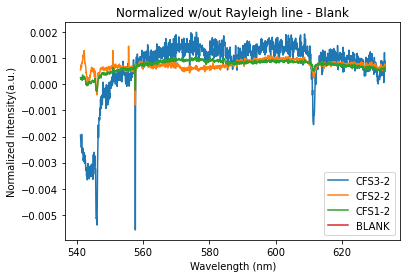

In [28]:
#Plotting Normalized w/out Rayleigh line in Wavelength (nm)
#probably dont need this everytime since IntCols is defined above
test='Intensity'
IntCols = [idx for idx in df_signal_normalized if idx.lower().startswith(test.lower())]
#print(IntCols)
df_signal_normalized.plot(x='Wavelength_1', y=IntCols)
plt.title('Normalized w/out Rayleigh line - Blank')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [29]:
#Raman Sh cm^-1 and Normalized Intensity 
#setup numbers for conversion 
test='Intensity'
test2='Wavelength'
IntCols = [idx for idx in df_signal_normalized if idx.lower().startswith(test.lower())]
WavCols= [idx for idx in df_signal_normalized if idx.lower().startswith(test2.lower())]
Excitation_Wavelength=532
a=10**7/Excitation_Wavelength
#for columns in df if they start with Intensity 
#apply calculation to columns that start with Intensity 
df_signal_raman_shift=pd.DataFrame()
for col in df_signal_normalized:
    if col.startswith(test):
        df_signal_raman_shift[IntCols] = (df_signal_normalized[IntCols])
    if col.startswith(test2):
        df_signal_raman_shift[WavCols]= (df_signal_normalized[WavCols].apply(lambda x:-10**7/x + a))
print(df_signal_raman_shift)

      Wavelength_1  Wavelength_2  Wavelength_3  Wavelength_4  Intensity_1  \
0       317.056238    317.056238    317.056238    317.056238    -0.001951   
1       319.368928    319.368928    319.368928    319.368928    -0.002139   
2       321.681039    321.681039    321.681039    321.681039    -0.001957   
3       323.992571    323.992571    323.992571    323.992571    -0.002414   
4       326.303525    326.303525    326.303525    326.303525    -0.002414   
...            ...           ...           ...           ...          ...   
1352   2991.618719   2991.618719   2991.618719   2991.618719     0.000794   
1353   2993.310460   2993.310460   2993.310460   2993.310460     0.000788   
1354   2995.001839   2995.001839   2995.001839   2995.001839     0.001218   
1355   2996.692856   2996.692856   2996.692856   2996.692856     0.000484   
1356   2998.383511   2998.383511   2998.383511   2998.383511     0.000885   

      Intensity_2  Intensity_3  Intensity_4  
0        0.000553     0.00025

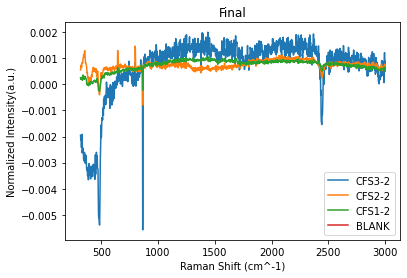

In [30]:
#Plotting Normalized w/out Rayleigh line in Wavenumber (cm^-1)
test='Intensity'
IntCols = [idx for idx in df_signal_raman_shift if idx.lower().startswith(test.lower())]
#print(IntCols)2
df_signal_raman_shift.plot(x='Wavelength_1', y=IntCols)
plt.title('Final')
plt.xlabel('Raman Shift (cm^-1)')
plt.ylabel('Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [31]:
# try:
#     IntCols6 = [idx for idx in df_signal_no_rayleigh if idx.lower().startswith(test.lower())]
#     if name in IntCols6==blank_int_name:
#         print("a")

In [32]:
IntCols5 = [idx for idx in df_signal if idx.lower().startswith(test.lower())]
y5=IntCols5

# try:
#     IntCols6 = [idx for idx in df_signal_no_rayleigh if idx.lower().startswith(test.lower())]
#     if name in IntCols6==blank_int_name:
#         print("a")
# else:
#     pass

IntCols6 = [idx for idx in df_signal_no_rayleigh if idx.lower().startswith(test.lower())]
y6=IntCols6
IntCols7 = [idx for idx in df_signal_normalized if idx.lower().startswith(test.lower())]
y7=IntCols7
IntCols8 = [idx for idx in df_signal_raman_shift if idx.lower().startswith(test.lower())]
y8=IntCols8
# print

In [33]:
print(y5)

['Intensity_1', 'Intensity_2', 'Intensity_3', 'Intensity_4']


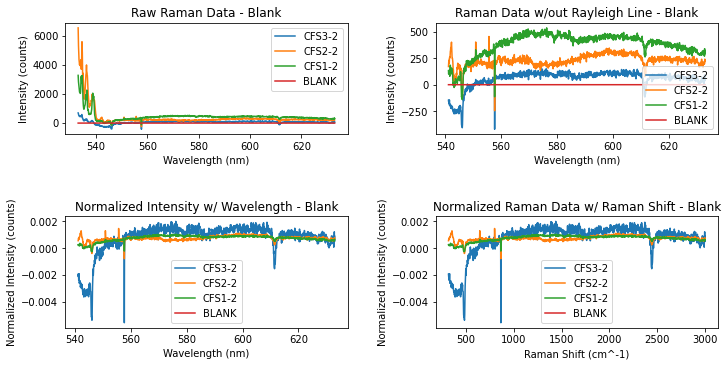

In [34]:
#setup 4 subplots 
fig, ((ax1, ax2),(ax3, ax4))= plt.subplots(nrows=2, ncols=2,figsize=(10,5))
#raw data plot
ax1=plt.subplot(2,2,1)
df_signal.plot(x='Wavelength_1', y=y5, ax=ax1)
ax1.set_title("Raw Raman Data - Blank")
plt.legend(molecule_names)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Intensity (counts)')
#witout rayleigh line
ax2=plt.subplot(2,2,2)
df_signal_no_rayleigh.plot(x='Wavelength_1', y=y6, ax=ax2)
ax2.set_title("Raman Data w/out Rayleigh Line - Blank")
plt.legend(molecule_names)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Intensity (counts)')
#normalized
ax3=plt.subplot(2,2,3)
df_signal_normalized.plot(x='Wavelength_1', y=y7, ax=ax3)
ax3.set_title("Normalized Intensity w/ Wavelength - Blank")
plt.legend(molecule_names)
ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('Normalized Intensity (counts)')
#raman shift
ax4=plt.subplot(2,2,4)
df_signal_raman_shift.plot(x='Wavelength_1', y=y8, ax=ax4)
ax4.set_title("Normalized Raman Data w/ Raman Shift - Blank")
plt.legend(molecule_names)
ax4.set_xlabel('Raman Shift (cm^-1)')
ax4.set_ylabel('Normalized Intensity (counts)')
#add y x lables and titles
#fix spacing of graphs
#Intensity (counts)
#Normalized Intensity (counts)
plt.tight_layout(pad=0.4, w_pad=3.0, h_pad=3.5)
# plt.savefig("/home/jasonk0401/Desktop/UROP/RamanGraphs4.png", dpi=300)
plt.show()